**DSCI 100 Project Final Report**

**Introduction**

In online games, not all players engage at the same level. Some log in for quick sessions, while others contribute much more by playing consistently and for longer periods. Game developers and researchers want to understand what factors drive player engagement so they can design better experiences and boost engagement. Characteristics like a player's age and game experience might influence how actively they participate. 

In this project, we explore data collected from Plaicraft, a Minecraft research server created by the PLAI research group in the UBC Department of Computer Science, led by Professor Frank Wood. The objective of running Plaicraft is to obtain human gameplay data to train artificial general intelligence (AGI) agents for video games (Smith, 2025). The provided dataset includes logs of player sessions and basic player information, allowing us to analyze how individual characteristics relate to gaming behaviours.


The research question is: Can a player’s game experience and age help predict if they’ll be a high contributor (i.e., someone who plays more than half an hour)? Identifying high contributors is important because they will generate richer gameplay data that researchers can use to train AGI models.

Dataset Description:

The given dataset is made up of two structured files:

*players.csv* - Contains information of 197 unique players and includes the 7 following variables:
- experience: categorical, self-reported skill level (Pro, Veteran, Regular, Amateur)
- subscribe: Boolean, whether the player subscribed to the server newsletter
- hashedEmail: identifier, anonymized unique player ID
- played_hours: numeric, total hours the player has spent in-game
- name: string, player's chosen username
- gender: categorical, player's gender identity (Male, Female, Non-binary etc)
- Age: numeric, player's age in years 


*sessions.csv* - Contains 1536 individual gameplay sessions with the 5 following variables:
- hashedEmail: identifier, anonymized unique player ID
- start_time and end_time: start and end of each gameplay session
- original_start_time and original_end_time: unix epoch timestaps


Player characteristics (e.g., age, experience, and gender) were self-reported, while gameplay sessions were recorded automatically through screen monitoring. Consequently, there may be some subjectivity in self-reported variables, especially in categorical fields like experience. However, since the game server automatically disconnected players who were inactive for more than 3 minutes, we can be confident that the recorded playtime is reliable.

For this project, we focus on the players.csv file, since it contains the variables needed to evaluate how player characteristics relate to total playtime, which we use to determine if a player is a high contributor.

**Methods and Results**

To conduct this analysis, players were categorized based on their total playtime:
- High contributors ( >0.5 hours): players who show significant engagement by playing for more than 30 minutes
- Low contributors: (0.5 hours or less): players with limited engagement by playing for only 30 minutes or less

This classification allows us to investigate whether certain player characteristics, specifically age and experience, are predictive of higher engagement levels.

We began by loading the necessary libraries and preparing the dataset.

In [2]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(themis)
library(cowplot)

players_url <- "https://raw.githubusercontent.com/ashleyan1207/DSCI-100-Project/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/ashleyan1207/DSCI-100-Project/refs/heads/main/sessions.csv"

players <- read_csv(players_url)
sessions <- read_csv(sessions_url)

players <- players |>
    mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")),
           contributor_level = case_when(
              played_hours > 0.5 ~ "High",
              played_hours <= 0.5 ~ "Low")) |>
    mutate(contributor_level = factor(contributor_level)) |>
    drop_na()
print("Figure 1: Player Dataset")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Figure 1: Player Dataset"


experience,subscribe,hashedEmail,played_hours,name,gender,Age,contributor_level
<fct>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,High
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,High
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,Low
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,High
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,Low
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,Low
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,Low
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,Low
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,Low


From the players dataset, most individuals reported having an Amateur level of experience. However, the group that logged the most total playtime were those with a Regular experience level (Figure 2). By defining high contributors as players who played for more than 30 minutes (0.5 hours), we found that 53 players met this threshold, with an average age of 20.6 years (Figure 3). The remaining 141 players were classified as low contributors, making up the majority. Due to this imbalance between high and low contributors, it is important to scale and preprocess the data when building the classification model, to prevent bias toward the more frequent class.

In [9]:
avg_experience <- players |>
    group_by(experience) |>
    summarize(average_played_hours = mean(played_hours, na.rm = TRUE),
             average_age = mean(Age),
             count = n())

contributors <- players |>
    group_by(contributor_level) |>
    summarise(count = n(), 
             average_age = mean(Age))

print("Figure 2: Average Playtime and Age by Experience Level")
avg_experience
print("Figure 3: Contibutor Type Counts and Average Age")
contributors

[1] "Figure 2: Average Playtime and Age by Experience Level"


experience,average_played_hours,average_age,count
<fct>,<dbl>,<dbl>,<int>
Beginner,1.2485714,21.65714,35
Amateur,6.0174603,20.25397,63
Regular,18.7257143,20.60000,35
Pro,2.7846154,16.92308,13
Veteran,0.6479167,20.95833,48


[1] "Figure 3: Contibutor Type Counts and Average Age"


contributor_level,count,average_age
<fct>,<int>,<dbl>
High,53,20.64151
Low,141,20.47518


Our visualizations suggest that player engagement varies by experience level and age (Figure 4). Regular players accumulated the most playtime, while Pro players showed lower overall hours, possibly due to shorter, more focused sessions. Additionally, players aged around 15–25 contributed significantly more playtime than older or younger age groups. 

To determine whether these factors reliably predict high contributors (playtime >0.5 hours), we will use K-Nearest Neighbors (K-NN) classification. K-NN is well-suited for this task, because it handles categorical outcomes, works with multiple predictors, and doesn't require the data to follow any particular pattern, which is good since our data isn't perfectly balanced.

[1] "Figure 4: Visualizations of potential factors in the Players Dataset"


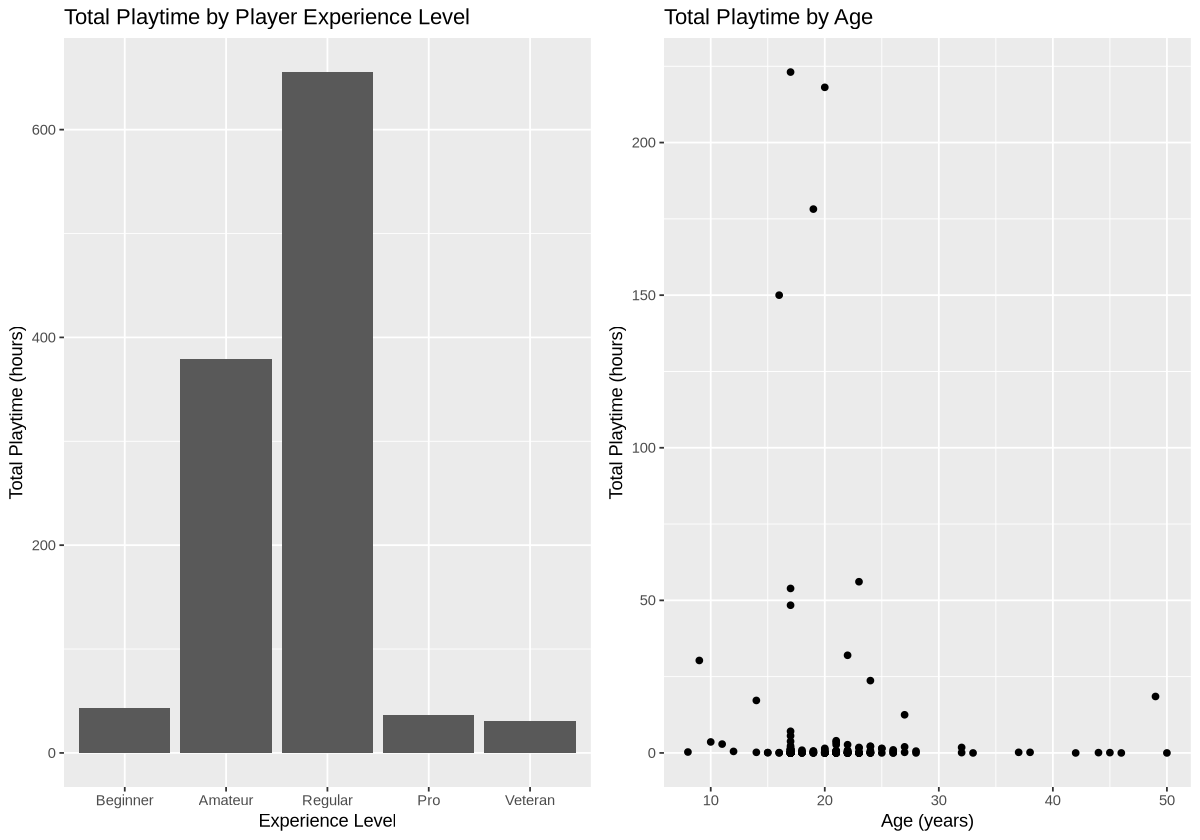

In [10]:
experience_playtime_plot <- ggplot(players, aes(x = experience, y = played_hours)) +
    geom_bar(stat = "identity") +
    labs(x= "Experience Level", y = "Total Playtime (hours)") +
    ggtitle("Total Playtime by Player Experience Level")

age_playtime_age <- ggplot(players, aes(x = Age, y = played_hours)) +
    geom_point() +
    labs(x = "Age (years)", y = "Total Playtime (hours)") +
    ggtitle("Total Playtime by Age")

options(repr.plot.width = 10, repr.plot.height = 7)
print("Figure 4: Visualizations of potential factors in the Players Dataset")
plot_grid(experience_playtime_plot, age_playtime_age, ncol = 2)
     

To implement K-NN classification, the dataset was first split into 70% training and 30% testing sets. This allows us to build the model on one portion of the data and then test how well it performs on unseen data. Since K-NN uses Euclidean distance to classify points, we assigned numerical labels to non-numeric factors, like experience. We also standardized the predictors using step_normalize(), which adjusts each feature to have a mean of 0 and a standard deviation of 1. This step is important due to the imbalance in the predictors. Additionally, because the "Low" contributor class heavily outweighs the "High" contributor class, we applied step_upsample() to balance the class distribution in the training data.

K-NN classifies observations based on the class of the majority of the k closest neighbors. To choose the best value for k, we used 5-fold cross-validation on the training set. This method splits the training data into five parts, trains the model on four parts, and tests it on the fifth, repeating the process five times. We tested k values from 1 to 10, and selected the one that gave us the highest classification accuracy.

[1] "Figure 5: Cross Validation Accuracy vs K-Neighbors"


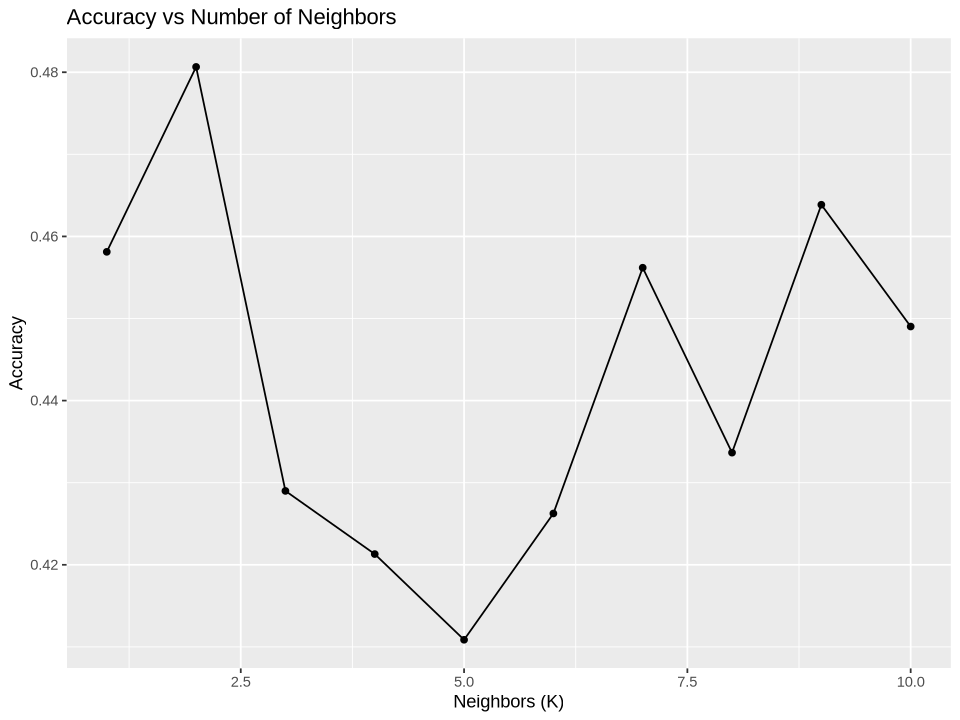

In [11]:
set.seed(2025) 
selected_players <- players  |>
    mutate(experience_label= as.numeric(experience)) |>
    select(contributor_level, experience, experience_label, Age)

players_split <- initial_split(selected_players, prop = 0.7, strata = contributor_level)  
players_training <- training(players_split)   
players_testing <- testing(players_split)

players_recipe <- recipe(contributor_level ~ experience_label + Age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(contributor_level, over_ratio = 1, skip = TRUE)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_vfold <- vfold_cv(players_training, v = 5, strata = contributor_level)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors (K)", y = "Accuracy") +
    ggtitle("Accuracy vs Number of Neighbors")

options(repr.plot.width = 8, repr.plot.height = 6)
print("Figure 5: Cross Validation Accuracy vs K-Neighbors")
cross_val_plot     

In [12]:
best_k <- knn_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)
best_k

[1] 2

Based on the plot generated from cross-validation results, the highest classification accuracy was achieved when k = 2 (Figure 5). As a result, k = 2 was selected as the optimal number of neighbors for the model.

Using this value, a K-NN classifier was built to make predictions based on the 2 nearest neighbors. After training, the model was applied to the test set using the predict() function. Since the true classifications for the test set are already known, model performance was evaluated by comparing predicted labels to the actual outcomes.

In [13]:
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_training)

players_predictions <- predict(players_fit, players_testing) |>
    bind_cols(players_testing)

mnist_metrics <- players_predictions |>
    metrics(truth = contributor_level, estimate = .pred_class)

players_conf_mat <- players_predictions |> 
      conf_mat(truth = contributor_level, estimate = .pred_class)

print("Figure 6: Classification Model Performance Metrics")
mnist_metrics
print("Figure 7: Confusion Matrix for KNN Classification (Test Set)")
players_conf_mat

[1] "Figure 6: Classification Model Performance Metrics"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4915254
kap,binary,-0.1508453


[1] "Figure 7: Confusion Matrix for KNN Classification (Test Set)"


          Truth
Prediction High Low
      High    4  18
      Low    12  25

After evaluating the model on the testing data, the classifier achieved an accuracy of approximately 49%. The model tended to overpredict the "High" contributor class, frequently misclassifying "Low" contributors as "High" (Figures 6 and 7). 

Further analysis and visualization of the data indicate that players most likely to contribute high amounts of data, defined by longer playtime, are typically newer players, such as those in the "Amateur" or "Regular" experience levels, and are generally within the 16–22 age range (Figure 8). These findings align closely with patterns observed in the data prior to applying the classification model (Figure 4).

[1] "Figure 8: Distribution of Predicted High Contributors By Experience and Age"


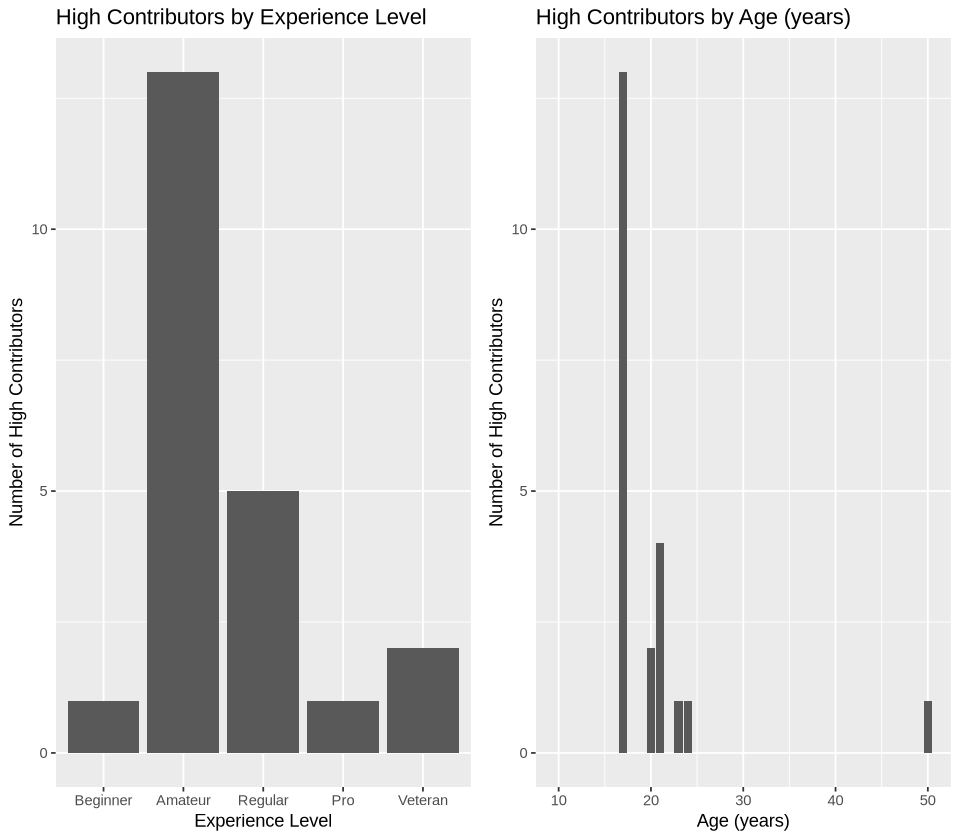

In [7]:
contributors_summary <- players_predictions |>
  group_by(experience_label, Age, experience, .pred_class) |>
  summarise(count = n(), .groups = "drop") |>
  pivot_wider(names_from = .pred_class, values_from = count, values_fill = 0)

players_experience_summary <- ggplot(contributors_summary, aes(x = experience, y = High)) +
    geom_bar(stat = "identity") +
    labs(title = "High Contributors by Experience Level", 
         x = "Experience Level", 
         y = "Number of High Contributors")

age_summary <- ggplot(contributors_summary, aes(x = Age, y = High)) +
    geom_bar(stat = "identity") +
    labs(title = "High Contributors by Age (years)", 
         x = "Age (years)", 
         y = "Number of High Contributors") 

options(repr.plot.width = 8, repr.plot.height = 7)
print("Figure 8: Distribution of Predicted High Contributors By Experience and Age")
plot_grid(players_experience_summary,age_summary, ncol = 2)

**Discussion**

*Summary of Findings*

This project aimed to predict whether a player's game experience and age could be used to identify high contributors, defined as those who played more than half an hour, on a Minecraft research server. A K-Nearest Neighbors classification model was used to make these predictions. The model achieved an accuracy of approximately 49% (Figure 6), with a tendency to misclassify "Low" contributors as "High" (Figure 7). This misclassification likely comes from the strong class imbalance in the dataset, where the majority of players were labeled as "Low" contributors.

Despite the limitations in predictive accuracy, the model and the visualizations highlighted a trend: high contributors were more likely to be newer players, specifically those with "Amateur" or "Regular" experience levels, and typically within the 16–22 age range (Figure 8). These patterns were also seen in the data analysis prior to modeling (Figure 4), suggesting that newer and younger players may be more engaged or curious, leading to longer play sessions.

*Expected Findings*

The findings mostly aligned with expectations formed during the initial data exploration. It was anticipated that younger players would spend more time on the server, which was supported by the classifier identifying 16–22 year-olds as frequent high contributors. However, it was originally expected that "Pro" or "Veteran" players would contribute more hours due to their familiarity with the game. Instead, "Amateur" and "Regular" players were more frequently classified as high contributors. This may suggest that early-stage engagement in the game motivates longer sessions among less experienced users.

*Impact of Findings*

These insights may be valuable for guiding recruitment strategies on the research server. To increase gameplay data collection, the team might prioritize attracting "Amateur" and "Regular" players in the 16–22 age range, who are more likely to be high contributors. Recruitment efforts could be targeted through online platforms or school programs where younger players are active. In addition, including game features that appeal to newer players, such as guided quests or learning rewards, could help engage this group longer.

*Future Questions*

Several questions emerged from this project that could be explored in future work:

- Why do less experienced players contribute more data than more experienced ones?
- Why do players that are 16-22 years-old spend the most time playing?
- How can we encourage players of ages younger than 16 and older than 22 to play more frequently, since the model found that they spend less time on the game?
  
Investigating these questions could lead to a deeper understanding of player behavior and more inclusive design choices for future research platforms.

**References**

Smith, A. (2025, June 15). Plaicraft.ai Launch. Pacific Laboratory for Artificial Intelligence. https://plai.cs.ubc.ca/2023/09/27/plaicraft/